In [ ]:
import os
import numpy as np
import pandas as pd
import h5py
import scipy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from IPython.display import HTML
import re
import MDAnalysis as md
from MDAnalysis.tests.datafiles import PSF, DCD, DCD2
from MDAnalysis.analysis.base import (AnalysisBase, AnalysisFromFunction, analysis_class)
import umap as UMAP


/home/mans/.conda/envs/mdsenv/lib/python3.8/site-packages/MDAnalysisTests/datafiles.py:229: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename


In [ ]:
#Function that creates the bin grid resulting in an ion map
def bin_plane(xyz, plane_size, L, num_bins, detector_eff=1.0, axis=1):
    if detector_eff > 1.0:
        raise ValueError("Detector efficiency cannot be over 100%.")

    
    # Create the grid
    grid_range = np.linspace(-plane_size / 2, plane_size / 2, num_bins)
    
    if axis == 0:
        grid = np.array([(-L, x, y) for y in grid_range for x in grid_range], dtype=np.float32)
        B1 = 1
        B2 = 2
    elif axis == 1:
        grid = np.array([(x, -L, y) for y in grid_range for x in grid_range], dtype=np.float32)
        B1 = 0
        B2 = 2
    elif axis == 2:
        grid = np.array([(x, y, -L) for y in grid_range for x in grid_range], dtype=np.float32)
        B1 = 1
        B2 = 0
    else:
        raise ValueError("Invalid axis value. Axis must be 0, 1, or 2.")
    
    # Filter out points that will never hit the plane based on their y-coordinate and the plane's location
    if L > 0:
        xyz = xyz[xyz[:, axis] < 0.0]  # Points above the plane when L > 0 will not hit
    elif L < 0:
        xyz = xyz[xyz[:, axis] > 0.0]  # Points below the plane when L < 0 will not hit

    # Calculate the hit locations on the plane
    k = -L / xyz[:, axis]
    hit_location = k[:, np.newaxis] * xyz

    # Initialize the bins
    bins = np.zeros((num_bins, num_bins), dtype=int)

    N = len(hit_location)
    M = int(detector_eff * N)
    
    keep_idx = np.random.choice(N, M, replace=False)
    hit_location = hit_location[keep_idx]

    # Process each hit location
    for hit in hit_location:
        # Check if the hit is within the plane bounds
        if -plane_size / 2 <= hit[B1] <= plane_size / 2 and -plane_size / 2 <= hit[B2] <= plane_size / 2:
            # Find the closest grid point for the hit location
            distance = scipy.spatial.distance.cdist([hit], grid)
            closest_bin = np.argmin(distance)

            # Convert the linear index to 2D index and increment the corresponding bin
            y_idx, x_idx = divmod(closest_bin, num_bins)
            bins[y_idx, x_idx] += 1

    return bins.astype(np.int16)

Dimensionality reduction functions

In [ ]:
def PCA_analysis(img_data, n_components=2):
    # Create a numpy array of shape (len(img_data), bins, bins)
    data_array = np.array(img_data) 
    print(np.shape(data_array))
    # Reshape it into (len(img_data), bins*bins) so each row represents one sample
    data_matrix = data_array.reshape(len(img_data), -1) 
    data_matrix = np.array(data_matrix)
    print(np.shape(data_matrix))
    # Apply PCA
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(data_matrix)
    return transformed_data, pca

def TSNE_analysis(img_data, n_components=2, perplexity=50.0, random_state=None):
    # Convert the list of lists into a numpy array of shape (len(img_data), bins, bins)
    data_array = np.array(img_data)  
    
    # Reshape it into (len(img_data), bins*bins) so each row represents one sample
    data_matrix = data_array.reshape(len(img_data), -1)  
    
    # Apply TSNE
    tsne = TSNE(n_components=n_components, verbose=0, perplexity=perplexity, random_state=random_state)
    transformed_data = tsne.fit_transform(data_matrix)
    return transformed_data

def UMAP_analysis(img_data, n_components=2, n_neighbors=15, metric='euclidean', random_state=None):
    # Convert the list of lists into a numpy array of shape (len(img_data), bins, bins)
    data_array = np.array(img_data)  
    
    # Reshape it into (len(img_data), bins*bins) so each row represents one sample
    data_matrix = data_array.reshape(len(img_data), -1) 
    
    # Apply UMAP
    umap = UMAP.UMAP(n_components=n_components, n_neighbors=n_neighbors, metric=metric, random_state=random_state)
    transformed_data = umap.fit_transform(data_matrix)
    return transformed_data


#For sorting the lists
def extract_number(s):
    return int(''.join(filter(str.isdigit, s)))

#Normalization function
def normalize(img):
    img = np.array(img)
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

Extract Radius of Gyration

In [ ]:
#What electric field
efield = '3e4'

# Taken from MDAnalysis webpage for "Writing your own trajectory analysis": https://userguide.mdanalysis.org/1.1.1/examples/analysis/custom_trajectory_analysis.html
def radgyr(atomgroup, masses, total_mass=None):
    # coordinates change for each frame
    coordinates = atomgroup.positions
    center_of_mass = atomgroup.center_of_mass()

    # get squared distance from center
    ri_sq = (coordinates-center_of_mass)**2
    # sum the unweighted positions
    sq = np.sum(ri_sq, axis=1)
    sq_x = np.sum(ri_sq[:,[1,2]], axis=1) # sum over y and z
    sq_y = np.sum(ri_sq[:,[0,2]], axis=1) # sum over x and z
    sq_z = np.sum(ri_sq[:,[0,1]], axis=1) # sum over x and y

    # make into array
    sq_rs = np.array([sq, sq_x, sq_y, sq_z])

    # weight positions
    rog_sq = np.sum(masses*sq_rs, axis=1)/total_mass
    # square root and return
    return np.sqrt(rog_sq)

#Sort the runs 0-99
cwd_long = f'/home/mans/E_{efield}'
E_folder = os.listdir(cwd_long) 
print(E_folder)
all_runs = [i for i in E_folder if re.match(r'run\d+', i)]
all_runs = sorted(all_runs, key=extract_number)
print(all_runs)

#Get RoG
all_rog = []
for run in all_runs:
    u = md.Universe(f'{cwd_long}/{run}/long.gro', f'{cwd_long}/{run}/long.trr')
    protein = u.select_atoms('protein')
    idx = protein.indices

    rog = md.analysis.base.AnalysisFromFunction(radgyr, u.trajectory,
                            protein, protein.masses,
                            total_mass=np.sum(protein.masses))
    rog.run(start=0, stop=1001, step=10)
    all_rog.append(rog)

print(len(all_rog))
print(all_rog[34].results['timeseries'].shape)

#Take specific RoG axis and add to flattened list
rog_list = []
labels = ['all', 'x-axis', 'y-axis', 'z-axis']

for rog_run in range(len(all_runs)):
    for col, label in zip(all_rog[rog_run].results['timeseries'].T, labels):
        if label == 'all':
            rog_list.append(col)

flattened_rog = np.concatenate(rog_list).tolist()

['run64', 'run5', 'copyToResults.sh', 'run65', 'run50', 'run43', 'run51', 'run42', 'run0', 'run35', 'RMSF', 'run11', 'oneConfPDB.sh', 'run38', 'template', 'run71', 'run41', 'run84', 'CA.ndx', 'run96', 'run95', 'run74', 'run32', 'run54', 'severalConfPDB.sh', 'run36', 'run90', 'run61', 'statesWithTime', 'run67', 'run9', 'run98', 'run19', 'run53', 'run7', 'run17', 'run30', 'run18', 'run31', 'run89', 'run77', 'gro_structures', 'run87', 'run24', 'run99', 'run29', 'run78', 'RMSD', 'run21', 'masterRMSF.sh', 'run60', 'run76', 'heatCapacity_E3e4.png', 'run70', 'run82', 'run97', 'movies', 'run6', 'run83', 'alldists.npy', 'run57', 'run26', 'run13', 'rmsd.sh', 'run46', 'run.sh', 'run63', 'ifRunSucceed.sh', 'run3', 'run52', 'run56', 'run1', 'run92', 'run28', 'run10', 'run33', 'run75', 'run27', 'run68', 'run80', 'run39', 'run34', 'run93', 'run88', 'run85', 'run25', 'run48', 'run94', 'run91', 'run81', 'run55', 'run72', 'do_dist.sh', 'run2', 'run22', 'run20', 'run45', 'run15', 'run23', 'states', 'run4

Extract all posdata from h5 file (lists are ordered by run)

In [ ]:
cwd = f'/home/mans/moldstruct_python/E_{efield}_mds'

run_dirs = os.listdir(f'{cwd}')
run_dirs.sort()
run_dirs = run_dirs[1:] #Contains all the runs (runxxx_mds)
run_dirs = sorted(run_dirs, key=extract_number)
allsim_posdata = []
print(run_dirs)
for run in run_dirs:
    
    fold_dirs = os.listdir(f'{cwd}/{run}') #Contains all the folds for that run (E_3/5e4_runxxx_0xxx_mds)
    fold_dirs.sort()    
    fold_dirs = fold_dirs[:-1]
    
    for fold in fold_dirs:
        try:
            content = (os.listdir(f'{cwd}/{run}/{fold}/'))
            content.sort()
            # If a MolDStruct simulation failed, the content in that folder will not match the content in a successful simulation folder.
            if content == [f'.{fold[:-4]}_exp.trr_offsets.npz', f'{fold[:-4]}.gro', f'{fold[:-4]}_exp.gro', f'{fold[:-4]}_exp.trr', 'additional_data', 'data.h5', 'ener.edr', 'kin.xvg', 'tot.xvg']:
                h5file = f'{cwd}/{run}/{fold}/data.h5'
                # Exctract the position data (unit displacement)
                with h5py.File(h5file, 'r') as file:   #how to open h5 file: h5dump name
                    group_path =f'E_{efield}_mds'
                    group = file[group_path]
                    pos_data = group["unit_displacement"][:]
                pos_data = np.array(pos_data)
                allsim_posdata.append(pos_data)
            else:
                fail_replace = np.zeros(shape=(1238, 3))
                allsim_posdata.append(fail_replace)
        except Exception as e:
            print(f'There is no {fold[:-4]}: {e}')


['run0_mds', 'run1_mds', 'run2_mds', 'run3_mds', 'run4_mds', 'run5_mds', 'run6_mds', 'run7_mds', 'run8_mds', 'run9_mds', 'run10_mds', 'run11_mds', 'run12_mds', 'run13_mds', 'run14_mds', 'run15_mds', 'run16_mds', 'run17_mds', 'run18_mds', 'run19_mds', 'run20_mds', 'run21_mds', 'run22_mds', 'run23_mds', 'run24_mds', 'run25_mds', 'run26_mds', 'run27_mds', 'run28_mds', 'run29_mds', 'run30_mds', 'run31_mds', 'run32_mds', 'run33_mds', 'run34_mds', 'run35_mds', 'run36_mds', 'run37_mds', 'run38_mds', 'run39_mds', 'run40_mds', 'run41_mds', 'run42_mds', 'run43_mds', 'run44_mds', 'run45_mds', 'run46_mds', 'run47_mds', 'run48_mds', 'run49_mds', 'run50_mds', 'run51_mds', 'run52_mds', 'run53_mds', 'run54_mds', 'run55_mds', 'run56_mds', 'run57_mds', 'run58_mds', 'run59_mds', 'run60_mds', 'run61_mds', 'run62_mds', 'run63_mds', 'run64_mds', 'run65_mds', 'run66_mds', 'run67_mds', 'run68_mds', 'run69_mds', 'run70_mds', 'run71_mds', 'run72_mds', 'run73_mds', 'run74_mds', 'run75_mds', 'run76_mds', 'run77_m

Inputs parameters for bin_plane

In [ ]:
plane_size = 200 #Plane size 
detector_distance = 10 #Detector distance 
num_bins = 50 #Number of bins (meaning how many bins that should fit the plane)


detector_eff = 1.0 # effciency of detector
axis = 2 #Where to place the detector relative to the reference frame of the datas
# 0 -> x
# 1 -> y
# 2 -> z
if axis == 0:
    axis_xyz = 'x'
elif axis == 1:
    axis_xyz = 'y'
else:
    axis_xyz = 'z'

#For image
all_imgs= []

for pos_data in allsim_posdata:
    img = np.ndarray(shape=(num_bins,num_bins))
    img = bin_plane(pos_data,plane_size,detector_distance,num_bins,detector_eff,axis)
    all_imgs.append(img)

print(len(all_imgs))
all_norm = normalize(all_imgs)

10100


Mean arrays and normalization for movies

In [ ]:
#To make the mean ion maps for all datasets

old_list = np.array(all_imgs)  # Convert to NumPy array
new_array = old_list.reshape(100, 101, num_bins, num_bins)  # Reshape into 100 sets of 101 values each (rows are runs, columns are folds)
mean_imgs = new_array.mean(axis=0)  # Compute mean for each column
#new_mean_list = new_mean_list.tolist()  # Convert back to a Python list if needed
print(len(mean_imgs))

#Normalization for each mean map is to get an easier visualization of the explosion shape evolution in movies, 
# Since we disregard intensity differences, the brightness between frames is unaltered.
norm_imgs = []
for img in mean_imgs:
    norm_imgs.append(normalize(img))

101


Detector image

img_5e4_z-axis_E100_200_10_50.png


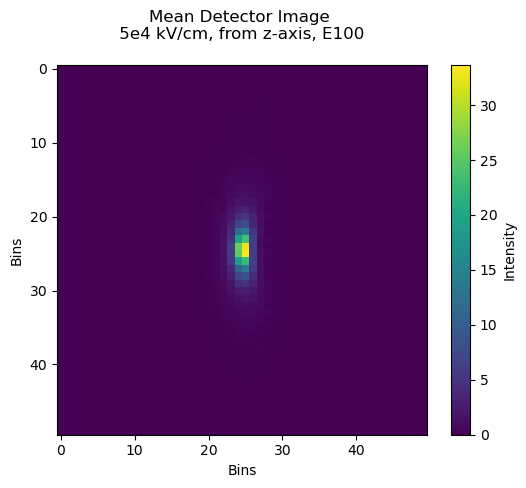

In [ ]:
# For detector image
fold_image = 100
plt.imshow(mean_imgs[fold_image])
cbar = plt.colorbar()
cbar.set_label('Intensity', fontsize=18)
cbar.ax.tick_params(labelsize=14)

plt.xlabel(f'Bins', fontsize=20)
plt.ylabel(f'Bins', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f'/home/mans/results/ionmaps_all_datasets/img_{efield}_{axis_xyz}-axis_E{fold_image}_{plane_size}_{detector_distance}_{num_bins}.png')
plt.show()

Explosionmap Movie

In [ ]:
import matplotlib.animation as animation
cax_frame = 0

# Set up the figure and axis
fig, ax = plt.subplots()
cax = ax.imshow(norm_imgs[cax_frame])
ax.set_title(f"")


# Function to update the plot for each frame
def update(frame):
    cax.set_data(norm_imgs[frame])
    ax.set_title(f"{efield} kV/cm, {axis_xyz}-axis, Frame: {frame}\nPL:{plane_size}, d:{detector_distance}, bins:{num_bins}")
    return cax,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(norm_imgs), interval=100, blit=True)

#Save the animation
save_path = f'/home/mans/pyscripts/exp_movie_{efield}_{axis_xyz}_d{detector_distance}_bin{num_bins}_cax{cax_frame}.mp4'
saveit = input(f'Save?: ')
if saveit == 'y':
    ani.save(save_path, writer='ffmpeg', fps=10)

# Display the animation in the notebook
HTML(ani.to_jshtml())

Dimensionality reduction plots

(10100, 50, 50)
(10100, 2500)
PCA_3e4_z_d10_bin50


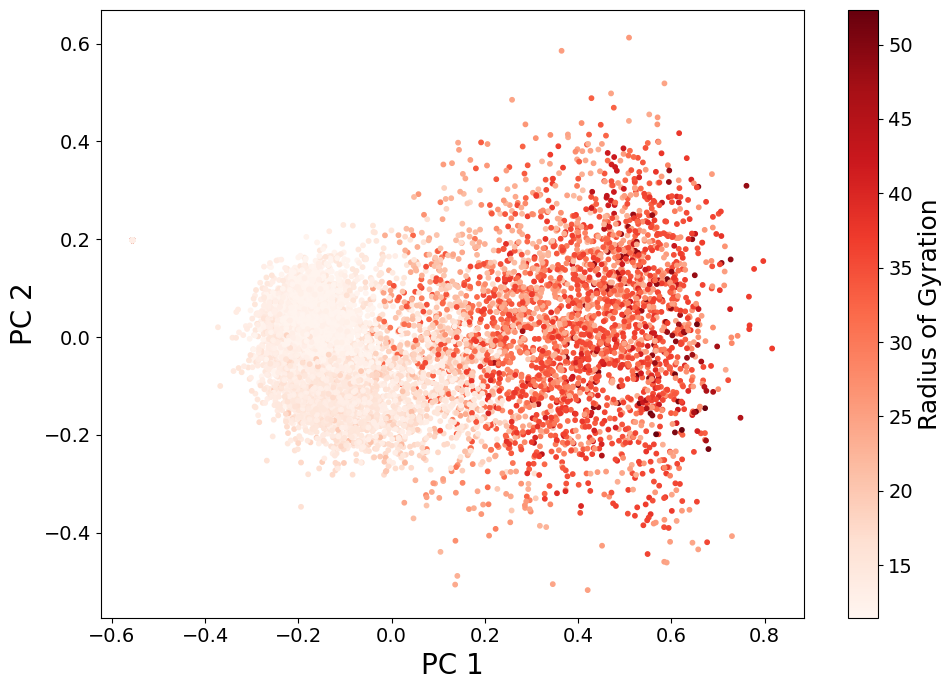

In [ ]:
#PCA 2D
pca_data, pca = PCA_analysis(all_norm, n_components=2)

plt.figure(figsize=(10, 7))
sc = plt.scatter(
    pca_data[:, 0], 
    pca_data[:, 1], 
    c=flattened_rog,     
    cmap='Reds',    
    s=10
)
cbar = plt.colorbar(sc)
cbar.set_label('Radius of Gyration', fontsize=18)
cbar.ax.tick_params(labelsize=14)  # Colorbar tick font size


plt.xlabel("PC 1", fontsize=20)
plt.ylabel("PC 2", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig(f'/home/mans/results/DR_plots/PCA_{efield}_{axis_xyz}_d{detector_distance}_bin{num_bins}_norm.png')
plt.show()

Eigenfaces

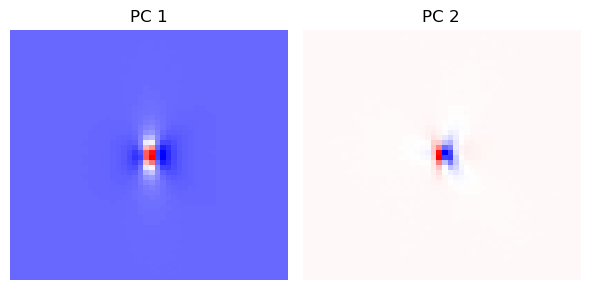

In [22]:
def plot_pca_eigenfaces(pca, n_lat, n_lon, n_components=2):
    fig, axes = plt.subplots(1, n_components, figsize=(3*n_components, 3))
    for i in range(n_components):
        ax = axes[i]

        # Each component is a vector, reshape to image
        img = pca.components_[i].reshape(n_lat, n_lon)   #(256//5+1, 256//5+1)
        ax.imshow(img, cmap='bwr', aspect='auto')
        ax.set_title(f'PC {i+1}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_pca_eigenfaces(pca, num_bins, num_bins, n_components=2)

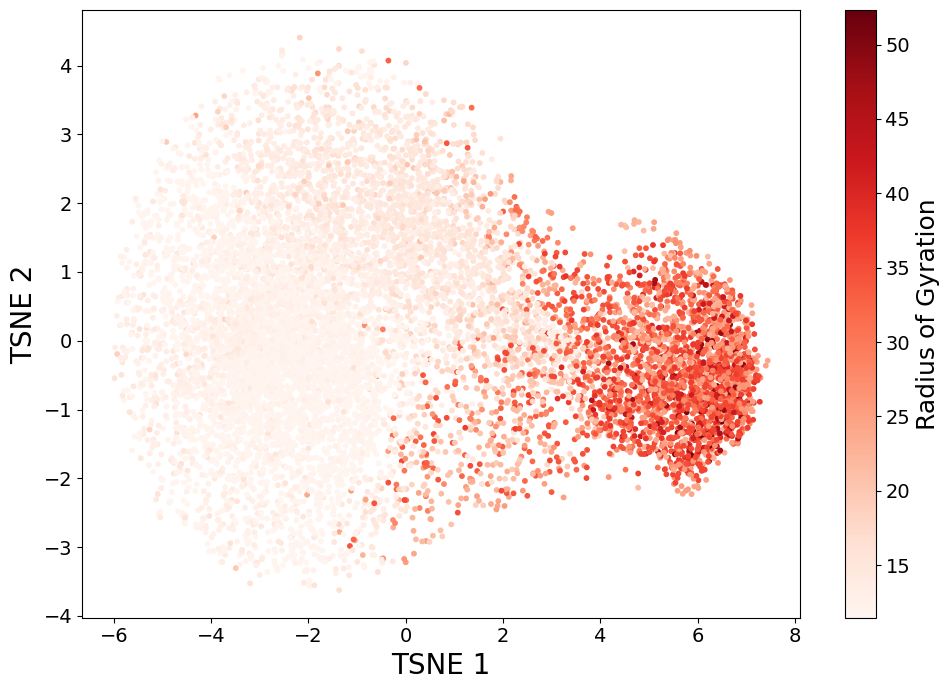

In [ ]:
#TSNE 2D
tsne_data = TSNE_analysis(all_norm, n_components=2, perplexity=500, random_state=None)

plt.figure(figsize=(10, 7))
sc = plt.scatter(
    tsne_data[:, 0], 
    tsne_data[:, 1], 
    c=flattened_rog,     
    cmap='Reds',      
    s=10
)
cbar = plt.colorbar(sc)
cbar.set_label('Radius of Gyration', fontsize=18)
cbar.ax.tick_params(labelsize=14)  # Colorbar tick font size


plt.xlabel("TSNE 1", fontsize=20)
plt.ylabel("TSNE 2", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig(f'/home/mans/results/DR_plots/TSNE_{efield}_{axis_xyz}_d{detector_distance}_bin{num_bins}_norm.png')
plt.show()

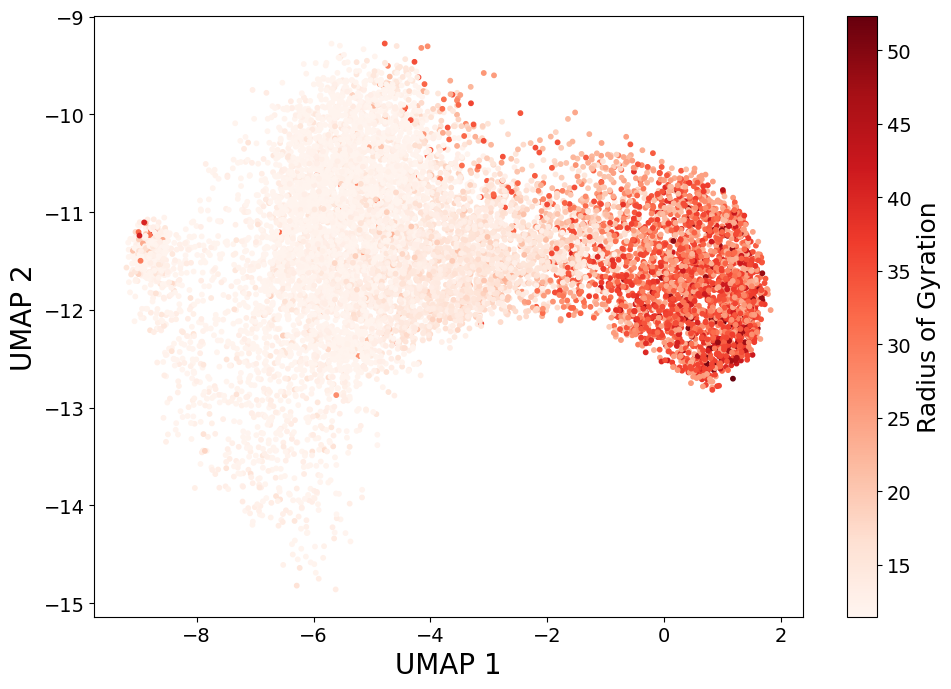

In [ ]:
#UMAP 2D
umap_data = UMAP_analysis(all_norm, n_components=2, n_neighbors=100, metric='euclidean', random_state=None)

plt.figure(figsize=(10, 7))
sc = plt.scatter(
    umap_data[:, 0], 
    umap_data[:, 1], 
    c=flattened_rog,     
    cmap='Reds',      
    s=10
)
cbar = plt.colorbar(sc)
cbar.set_label('Radius of Gyration', fontsize=18)
cbar.ax.tick_params(labelsize=14)  # Colorbar tick font size


plt.xlabel("UMAP 1", fontsize=20)
plt.ylabel("UMAP 2", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig(f'/home/mans/results/DR_plots/UMAP_{efield}_{axis_xyz}_d{detector_distance}_bin{num_bins}_norm.png')
plt.show()


3D plotting using Plotly

In [ ]:
#PCA 3D
print(f'PCA_3D_{efield}_{axis_xyz}_d{detector_distance}_bin{num_bins}.html')

pca_data = PCA_analysis(all_imgs, n_components=3)

# Convert PCA data into a dataframe
df = pd.DataFrame(pca_data, columns=["PC1", "PC2", "PC3"])
df["RoG"] = flattened_rog  # Assign colors by radius of gyration (sum of all axes)

# Plotly interactive 3D scatter plot
fig = px.scatter_3d(df, x="PC1", y="PC2", z="PC3", 
                    color="RoG", 
                    opacity=1, 
                    title=f'PCA Projection (3D) at {efield} kV/cm\nfrom the {axis_xyz}-axis',
                    color_continuous_scale='Reds')

# Reduce marker size
fig.update_traces(marker=dict(size=2))

saveit = input(f'Save?: ')
if saveit == 'y':
    fig.write_html(f"/home/mans/results/PCA_3D_{efield}_{axis_xyz}_d{detector_distance}_bin{num_bins}.html")

fig.show()


PCA_3D_5e4_z_d50_bin30.html
(10100, 30, 30)
(10100, 900)


In [ ]:
#TSNE in 3D

print(f'TSNE_3D_{efield}_{axis_xyz}_d{detector_distance}_bin{num_bins}.html')
tsne_data = TSNE_analysis(all_imgs, n_components=3, perplexity=50, random_state=None)
# Convert data into a dataframe
df = pd.DataFrame(tsne_data, columns=["TSNE 1", "TSNE 2", "TSNE 3"])
df["RoG"] = flattened_rog # Assign colors by radius of gyration (sum of all axes)

# PLotly interactive 3D scatter plot
fig = px.scatter_3d(df, x="TSNE 1", y="TSNE 2", z="TSNE 3", 
                    color=df["RoG"], 
                    opacity=1, 
                    title=f'TSNE Projection (3D) at {efield} kV/cm\nfrom the {axis_xyz}-axis',
                    color_continuous_scale='Reds')

# Reduce dot size
fig.update_traces(marker=dict(size=2.5))

saveit = input(f'Save?: ')
if saveit == 'y':
    fig.write_html(f"/home/mans/results/TSNE_3D_{efield}_{axis_xyz}_d{detector_distance}_bin{num_bins}.html")
    
fig.show()

TSNE_3D_5e4_z_d50_bin30.html


In [ ]:
#UMAP 3d
print(f'UMAP_3D_{efield}_{axis_xyz}_d{detector_distance}_bin{num_bins}.html')

umap_data = UMAP_analysis(all_imgs, n_components=3, random_state=None)

# Convert data into DataFrame
df_umap = pd.DataFrame(umap_data, columns=["UMAP1", "UMAP2", "UMAP3"])
df_umap["RoG"] = flattened_rog # Assign colors by radius of gyration (sum of all axes)

# Plotly interactive 3D scatter plot
fig = px.scatter_3d(df_umap, x="UMAP1", y="UMAP2", z="UMAP3", 
                    color="RoG", 
                    opacity=1, 
                    title=f"UMAP Projection (3D) at {efield} kV/cm\nfrom the {axis_xyz}-axis",
                    color_continuous_scale='Reds')

# Reduce marker size
fig.update_traces(marker=dict(size=2))

saveit = input(f'Save?: ')
if saveit == 'y':
    fig.write_html(f"/home/mans/results/UMAP_3D_{efield}_{axis_xyz}_d{detector_distance}_bin{num_bins}.html")
    
fig.show()


UMAP_3D_5e4_z_d50_bin30.html
